# Classifying Chest X-rays with Cross-Modal Data Programming

This tutorial demonstrates how to build a deep learning model for classifying chest x-rays. The weak learning section is copied from the demo found [here](https://github.com/HazyResearch/cross-modal-ws-demo) by Dr. Dunnmon.

We begin by setting up our environment, importing relevant Python packages.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
# Making sure CUDA devices are visible!
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Importing pandas for data processing
import pandas as pd

# Import torch for deep learning framework
import torch

# Section 1: Setup

## 1.1: Loading and Splitting the Data

First, we set up the data dictionary and load data that we've already split for you into an (approximately) 80% train split, 10% development split, and 10% test split. We do this because we don't want to evaluate the model on the data it was trained on: it could just memorize the training data and be unable to generalize. We create the development split because we want to pick a model that does well on data it is not tested on, so while training on the train split, we save the model that does the best on the development set for later. Note that this may not necessarily be the model with the highest training accuracy, as models can "overfit" to the data and generalize poorly. So we further evaluate the model that did the best on the validation set on the test set to get an idea of how our model would do "in the real world" (unseen data that it should generalize to).

In [2]:
# Setting up data dictionary and defining data splits
data = {}
splits = ['train','dev','test']

for split in splits:
    data[split] = pd.read_csv(f'data/{split}_entries.csv')[['label','xray_paths','text']]
    # Adjusting labels to fit with Snorkel MeTaL labeling convention
    data[split]['label'][data[split]['label']==0] = 2
    perc_pos = sum(data[split]['label']==1)/len(data[split])
    print(f'{len(data[split])} {split} examples: {100*perc_pos:0.1f}% Abnormal')

2630 train examples: 63.8% Abnormal
376 dev examples: 63.0% Abnormal
378 test examples: 61.6% Abnormal


Each raw data point contains three fields: a text report, a label (normal or abnormal), and a set of image paths.  The original data, from the OpenI dataset, is maintained by [NIH](https://openi.nlm.nih.gov/faq.php).

You can see an example of a single data point below -- note that the raw label convention for our normal vs. abnormal classification problem is 1 for abnormal and 2 for abnormal.

In [3]:
sample = data['train'].iloc[0]
print('RAW TEXT:\n \n',sample['text'],'\n\n')
print('IMAGE PATHS: \n \n', sample['xray_paths'],'\n\n')
print('LABEL:', sample['label'])

RAW TEXT:
 
 COMPARISON: Chest x-XXXX XXXX INDICATION: XXXX in bathtub FINDINGS: The lungs and pleural spaces show no acute abnormality. Hyperexpanded lungs. Calcified right upper lobe granuloma, unchanged. Heart size and pulmonary vascularity within normal limits. No displaced rib fractures. IMPRESSION: 1. Hyperexpansion without acute pulmonary abnormality. 


IMAGE PATHS: 
 
 ./data/openi/xrays/CXR2824_IM-1245-13001.png 


LABEL: 1


And here we load in the image.

Image size:  torch.Size([3, 224, 224])


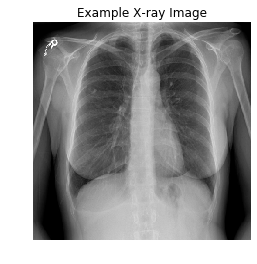

In [4]:
import matplotlib.pyplot as plt
from utils import get_data_loader
data_loader = get_data_loader(data['train']['xray_paths'].tolist(), data['train']['label'].tolist(), batch_size=32, shuffle=True)
img, label = data_loader.dataset[0]

print("Image size: ", img.shape)

plt.figure()
plt.imshow(img[0,:,:],cmap='gray')
plt.title('Example X-ray Image')
ax = plt.axis('off')

We see also that the image is of shape 3x224x224: the first dimension (3) is for the RGB channels, a common way to represent color images. Then the image is 224 pixels tall by 224 pixels wide, giving us a shape of 3x224x224.

## 1.2: Setup for Training    

Here we get ready to train a model. We need some setup to begin training with the MeTaL framework.

First we create "dataloaders" that will feed the data to our model.

In [5]:
Ys = [data['train']['label'].tolist(),
      data['dev']['label'].tolist(),
      data['test']['label'].tolist()]

loaders = {}

loaders['train'] = get_data_loader(data['train']['xray_paths'].tolist(), Ys[0], batch_size=32, shuffle=True)
loaders['dev'] = get_data_loader(data['dev']['xray_paths'].tolist(), Ys[1], batch_size=32, shuffle=False)
loaders['test'] = get_data_loader(data['test']['xray_paths'].tolist(), Ys[2], batch_size=32, shuffle=False)

The device variable created below tells our model whether it should train using a GPU or a CPU. Training deep learning models on GPUs is often *drastically* faster! This line of code automatically selects a GPU if one is available on your system.

In [6]:
# Defining device variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Section 2: Training Fully Supervised Models

## 2.1: Setup

When training models, there are a variety of "hyperparameters" that you can choose. The MeTaL framework can test different combinations of hyperparameters for you, but here we just define one learning rate (lr) and one regularization rate (l2). We also define some other variables telling MeTaL where to log outputs.

In [7]:
from metal.tuners import RandomSearchTuner
from metal.logging.tensorboard import TensorBoardWriter
from metal.end_model import EndModel

search_space = {
    "l2": [1e-4],
    "lr": [1e-4],
}
tuner_config = {"max_search": 1}


# Updating logging config
log_config = {"log_dir": "./run_logs", "run_name": 'openi_demo_fs'}


# Setting up logger and searcher
searcher = RandomSearchTuner(
    EndModel, 
    **log_config, 
    log_writer_class=TensorBoardWriter, 
    validation_metric='accuracy',
    seed=1701
)

Here we set our model to train for 5 epochs or full passes through the data.

In [8]:
train_kwargs = {
    "n_epochs": 10,
    "progress_bar":True
}

train_args = [loaders['train']]

## 2.2: Training a Basic Convolutional Neural Network

Here we load create a more basic convolutional neural network architecture for the classification. The architecture is taken from [here](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py).

In [9]:
import torch.nn as nn
from utils import Flatten

simple_cnn_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=7, stride=4, padding=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(32, 32, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    Flatten(),
    nn.Linear(1152,2),
)

# Create pytorch model following the AlexNet architecture
num_classes = 2


# Initializing input module
init_args = [[2]]
init_kwargs = {
    "input_module": simple_cnn_model, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

Now we can train our model!

In [10]:
simple_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=None,
    clean_up=False
)


Network architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=2, bias=True)
)

[0] Testing {'l2': 0.0001, 'lr': 0.0001}
Using GPU...


[1 epo]: TRAIN:[loss=0.656] VALID:[accuracy=0.630]
Saving model at iteration 1 with best score 0.630



[2 epo]: TRAIN:[loss=0.628] VALID:[accuracy=0.665]
Saving model at iteration 2 with best score 0.665



[3 epo]: TRAIN:[loss=0.609] VALID:[accuracy=0.678]
Saving model at iteration 3 with best score 0.678



[4 epo]: TRAIN:[loss=0.599] VALID:[accuracy=0.684]
Saving model at iteration 4 with best score 0.684



[5 epo]: TRAIN:[loss=0.593] VALID:[accuracy=0.686]
Saving model at iteration 5 with best score 0.686



[6 epo]: TRAIN:[loss=0.588] VALID:[accuracy=0.689]
Saving model at iteration 6 with best score 0.689



[7 epo]: TRAIN:[loss=0.581] VALID:[accuracy=0.684]



[8 epo]: TRAIN:[loss=0.576] VALID:[accuracy=0.673]



[9 epo]: TRAIN:[loss=0.567] VALID:[accuracy=0.686]



[10 epo]: TRAIN:[loss=0.563] VALID:[accuracy=0.702]
Saving model at iteration 10 with best score 0.702

Restoring best model from iteration 10 with score 0.702
Finished Training
Accuracy: 0.702
        y=1    y=2   
 l=1    221    16    
 l=2    96     43    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0001, 'lr': 0.0001}
Best score: 0.7021276595744681


Finally, we can see its performance on the test set.

In [11]:
print("Evaluating Simple Model")
simple_scores = simple_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

Evaluating Simple Model
Accuracy: 0.661
Precision: 0.674
Recall: 0.871
F1: 0.760
Roc-auc: 0.713


We see that the test accuracy is a little far from the validation accuracy, so we know our model has overfit to the data a little. There are ways to overcome this including regularization, more training data, and better hyperparameter search.

# Section 3: Common Pitfalls

## 3.1 Lack of Data

A common deep learning pitfall is not supplying a model enough data. In this case, the model will struggle to generalize.

Below, we select 10% of the training data to use as a smaller training set.

In [12]:
loaders['small_train'] = get_data_loader(data['train']['xray_paths'].tolist()[:26], Ys[0][:26], batch_size=32, shuffle=True)
train_args = [loaders['small_train']]

init_kwargs = {
    "input_module": simple_cnn_model, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

Then we train our same model on this data.

In [13]:
simple_model_less_data = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=2, bias=True)
)

[0] Testing {'l2': 0.0001, 'lr': 0.0001}
Using GPU...


[1 epo]: TRAIN:[loss=0.690] VALID:[accuracy=0.628]
Saving model at iteration 1 with best score 0.628



[2 epo]: TRAIN:[loss=0.682] VALID:[accuracy=0.630]
Saving model at iteration 2 with best score 0.630



[3 epo]: TRAIN:[loss=0.675] VALID:[accuracy=0.630]



[4 epo]: TRAIN:[loss=0.668] VALID:[accuracy=0.630]



[5 epo]: TRAIN:[loss=0.662] VALID:[accuracy=0.630]



[6 epo]: TRAIN:[loss=0.657] VALID:[accuracy=0.630]



[7 epo]: TRAIN:[loss=0.652] VALID:[accuracy=0.630]



[8 epo]: TRAIN:[loss=0.647] VALID:[accuracy=0.630]



[9 epo]: TRAIN:[loss=0.642] VALID:[accuracy=0.630]



[10 epo]: TRAIN:[loss=0.638] VALID:[accuracy=0.630]

Restoring best model from iteration 2 with score 0.630
Finished Training
Accuracy: 0.630
        y=1    y=2   
 l=1    237     0    
 l=2    139     0    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0001, 'lr': 0.0001}
Best score: 0.6303191489361702


We can evaluate the model on the test set here to see its ability to generalize.

In [14]:
print("Evaluating model trained on full training data set on test set")
scores = simple_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

print("\n\nEvaluating model trained on less data on test set")
scores = simple_model_less_data.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)


Evaluating model trained on full training data set on test set
Accuracy: 0.661
Precision: 0.674
Recall: 0.871
F1: 0.760
Roc-auc: 0.713


Evaluating model trained on less data on test set
Accuracy: 0.616
Precision: 0.616
Recall: 1.000
F1: 0.763
Roc-auc: 0.466


We notice that the models with the same architecture and hyperparameters have different performance on the test set. The model trained on less data is actually only predicting abnormal classes and is completely unable to generalize.

## 3.2 Low-Quality Labels

Here we fake low-quality labels by randomly flipping each label (changing form normal to abnormal or abnormal to normal) with some probability. This simulates the people doing the data labeling giving the incorrect label to the data with some probability.

In [15]:
import random
random.seed(0)

flip_prob = .5

bad_Ys = []
for ys in Ys:
    bad_ys = ys.copy()
    for i in range(len(bad_ys)):
        # Flip the label with random probability
        if random.random() < flip_prob:
            if bad_ys[i] == 1:
                bad_ys[i] = 2
            else:
                bad_ys[i] = 1
    bad_Ys.append(bad_ys)

In [16]:
loaders['bad_train'] = get_data_loader(data['train']['xray_paths'].tolist(), bad_Ys[0], batch_size=32, shuffle=True)
loaders['bad_dev'] = get_data_loader(data['dev']['xray_paths'].tolist(), bad_Ys[1], batch_size=32, shuffle=True)
train_args = [loaders['bad_train']]


init_kwargs = {
    "input_module": simple_cnn_model, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

In [17]:
sabotaged_model = searcher.search(
    search_space,
    loaders['bad_dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=2, bias=True)
)

[0] Testing {'l2': 0.0001, 'lr': 0.0001}
Using GPU...


[1 epo]: TRAIN:[loss=0.694] VALID:[accuracy=0.439]
Saving model at iteration 1 with best score 0.439



[2 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.439]



[3 epo]: TRAIN:[loss=0.692] VALID:[accuracy=0.580]
Saving model at iteration 3 with best score 0.580



[4 epo]: TRAIN:[loss=0.691] VALID:[accuracy=0.428]



[5 epo]: TRAIN:[loss=0.691] VALID:[accuracy=0.449]



[6 epo]: TRAIN:[loss=0.689] VALID:[accuracy=0.590]
Saving model at iteration 6 with best score 0.590



[7 epo]: TRAIN:[loss=0.688] VALID:[accuracy=0.521]



[8 epo]: TRAIN:[loss=0.687] VALID:[accuracy=0.495]



[9 epo]: TRAIN:[loss=0.685] VALID:[accuracy=0.545]



[10 epo]: TRAIN:[loss=0.682] VALID:[accuracy=0.473]

Restoring best model from iteration 6 with score 0.590
Finished Training
Accuracy: 0.590
        y=1    y=2   
 l=1    21     138   
 l=2    16     201   
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0001, 'lr': 0.0001}
Best score: 0.5904255319148937


In [18]:
print("Evaluating model trained on original training data set on test set")
scores = simple_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

print("\n\nEvaluating model trained on sabotaged training data on test set")
scores = sabotaged_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)


Evaluating model trained on original training data set on test set
Accuracy: 0.661
Precision: 0.674
Recall: 0.871
F1: 0.760
Roc-auc: 0.713


Evaluating model trained on sabotaged training data on test set
Accuracy: 0.389
Precision: 0.518
Recall: 0.124
F1: 0.201
Roc-auc: 0.456


## 3.3 Overfitting (No regularization)

In [21]:
search_space = {
    "l2": [0.0], # no regularization
    "lr": [3e-3],
}

In [22]:
from torchvision import models
# model = models.alexnet(num_classes=2)
model = simple_cnn_model

In [23]:
train_kwargs = {
    "n_epochs": 10,
    "progress_bar":True
}

# Initializing input module
init_args = [[2]]
init_kwargs = {
    "input_module": model, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

overfitted_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=2, bias=True)
)

[0] Testing {'l2': 0.0, 'lr': 0.003}
Using GPU...


[1 epo]: TRAIN:[loss=0.698] VALID:[accuracy=0.630]
Saving model at iteration 1 with best score 0.630



[2 epo]: TRAIN:[loss=0.694] VALID:[accuracy=0.630]



[3 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[4 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[5 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[6 epo]: TRAIN:[loss=0.694] VALID:[accuracy=0.630]



[7 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[8 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[9 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[10 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]

Restoring best model from iteration 1 with score 0.630
Finished Training
Accuracy: 0.630
        y=1    y=2   
 l=1    237     0    
 l=2    139     0    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0, 'lr': 0.003}
Best score: 0.6303191489361702


In [24]:
search_space["l2"] = 1e-3

# Initializing input module
init_args = [[2]]
init_kwargs = {
    "input_module": model, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1700,
}

regularized_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=2, bias=True)
)

[0] Testing {'lr': 0.003}
Using GPU...


[1 epo]: TRAIN:[loss=0.699] VALID:[accuracy=0.630]
Saving model at iteration 1 with best score 0.630



[2 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[3 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[4 epo]: TRAIN:[loss=0.694] VALID:[accuracy=0.630]



[5 epo]: TRAIN:[loss=0.694] VALID:[accuracy=0.630]



[6 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[7 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[8 epo]: TRAIN:[loss=0.697] VALID:[accuracy=0.630]



[9 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]



[10 epo]: TRAIN:[loss=0.693] VALID:[accuracy=0.630]

Restoring best model from iteration 1 with score 0.630
Finished Training
Accuracy: 0.630
        y=1    y=2   
 l=1    237     0    
 l=2    139     0    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.001, 'lr': 0.003}
Best score: 0.6303191489361702


In [25]:
print("\n\nEvaluating model trained with no regularization")
scores = overfitted_model.score(
    loaders['train'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print()
scores = overfitted_model.score(
    loaders['dev'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print()
scores = overfitted_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print("\n\nEvaluating model trained with regularization")
scores = simple_model.score(
    loaders['train'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print()
scores = simple_model.score(
    loaders['dev'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print()
scores = simple_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)



Evaluating model trained with no regularization
Accuracy: 0.638
Precision: 0.638
Recall: 1.000
F1: 0.779
Roc-auc: 0.498

Accuracy: 0.630
Precision: 0.630
Recall: 1.000
F1: 0.773
Roc-auc: 0.497

Accuracy: 0.616
Precision: 0.616
Recall: 1.000
F1: 0.763
Roc-auc: 0.504


Evaluating model trained with regularization
Accuracy: 0.713
Precision: 0.717
Recall: 0.910
F1: 0.802
Roc-auc: 0.762

Accuracy: 0.702
Precision: 0.697
Recall: 0.932
F1: 0.798
Roc-auc: 0.731

Accuracy: 0.661
Precision: 0.674
Recall: 0.871
F1: 0.760
Roc-auc: 0.713


So we can see that the model without regularization has a higher disparity between train and val/test metrics compared wih the model trained with regularization. Generally a higher disparity between train and val metrics means worse generalizability.

# Section 4: Training Better Deep Learning Models

## 4.1: Training an Advanced Deep Learning Model

We can reuse most of the variables we created before. The only difference is that we will use a more powerful architecture that should give us better results.

In [26]:
from torchvision import models

# Create pytorch model
num_classes = 2
resnet = models.resnet18(num_classes=2, pretrained=False)

train_args = [loaders["train"]]

# Use a better learning rate for this model.
search_space = {
    "l2": [1e-4],
    "lr": [1e-4],
}


# Initializing input module
init_kwargs = {
    "input_module": resnet, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

And then we train.

In [27]:
advanced_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

[1 epo]: TRAIN:[loss=0.641] VALID:[accuracy=0.644]
Saving model at iteration 1 with best score 0.644



[2 epo]: TRAIN:[loss=0.578] VALID:[accuracy=0.596]



[3 epo]: TRAIN:[loss=0.492] VALID:[accuracy=0.684]
Saving model at iteration 3 with best score 0.684



[4 epo]: TRAIN:[loss=0.413] VALID:[accuracy=0.638]



[5 epo]: TRAIN:[loss=0.292] VALID:[accuracy=0.686]
Saving model at iteration 5 with best score 0.686



[6 epo]: TRAIN:[loss=0.269] VALID:[accuracy=0.657]



[7 epo]: TRAIN:[loss=0.144] VALID:[accuracy=0.641]



[8 epo]: TRAIN:[loss=0.104] VALID:[accuracy=0.646]



[9 epo]: TRAIN:[loss=0.065] VALID:[accuracy=0.678]



[10 epo]: TRAIN:[loss=0.023] VALID:[accuracy=0.686]

Restoring best model from iteration 5 with score 0.686
Finished Training
Accuracy: 0.686
        y=1    y=2   
 l=1    200    37    
 l=2    81     58    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0001, 'lr': 0.0001}
Best score: 0.6861702127659575


We note that the performance here is worse than it was for our simple model: this is probably because this architecture is very large and complex, so we would need to train it for longer to achieve similar results, but this architecture shuold also allow us to surpass the best performance of the simple model if trained sufficiently long and with good hyperparameters.

## 4.2: Training a Pretrained Advanced Deep Learning Model

We can also reuse models trained on other datasets. The advantage of this is that these models have been trained on millions of images and have become excellent feature extractors that we can adapt to our specific task.

In torch, this requires just changing one line of code! We set "pretrained" to "True" in the construction of the resnet model.

In [28]:
# Create pytorch model
num_classes = 2
resnet = models.resnet18(pretrained=True)
last_layer_input_size = int(resnet.fc.weight.size()[1])
resnet.fc = torch.nn.Linear(last_layer_input_size, num_classes)

# Initializing input module
init_kwargs = {
    "input_module": resnet, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "device": device,
    "seed": 1701,
}

We train again.

In [29]:
advanced_pretrained_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

[1 epo]: TRAIN:[loss=0.593] VALID:[accuracy=0.702]
Saving model at iteration 1 with best score 0.702



[2 epo]: TRAIN:[loss=0.342] VALID:[accuracy=0.665]



[3 epo]: TRAIN:[loss=0.117] VALID:[accuracy=0.689]



[4 epo]: TRAIN:[loss=0.048] VALID:[accuracy=0.710]
Saving model at iteration 4 with best score 0.710



[5 epo]: TRAIN:[loss=0.023] VALID:[accuracy=0.689]



[6 epo]: TRAIN:[loss=0.062] VALID:[accuracy=0.689]



[7 epo]: TRAIN:[loss=0.069] VALID:[accuracy=0.676]



[8 epo]: TRAIN:[loss=0.115] VALID:[accuracy=0.681]



[9 epo]: TRAIN:[loss=0.081] VALID:[accuracy=0.681]



[10 epo]: TRAIN:[loss=0.030] VALID:[accuracy=0.684]

Restoring best model from iteration 4 with score 0.710
Finished Training
Accuracy: 0.710
        y=1    y=2   
 l=1    208    29    
 l=2    80     59    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0001, 'lr': 0.0001}
Best score: 0.7101063829787234


## 4.3 Comparison

Then we evaluate all three models on the test set. The pretrained advanced model should have done the best.

In [30]:
print("Evaluating Simple Model")
simple_scores = simple_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

print("\n\nEvaluating Advanced Model")
advanced_scores = advanced_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

print("\n\nEvaluating Pretrained Advanced Model")
advanced_pretrained_scores = advanced_pretrained_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

Evaluating Simple Model
Accuracy: 0.661
Precision: 0.674
Recall: 0.871
F1: 0.760
Roc-auc: 0.713


Evaluating Advanced Model
Accuracy: 0.648
Precision: 0.680
Recall: 0.811
F1: 0.740
Roc-auc: 0.682


Evaluating Pretrained Advanced Model
Accuracy: 0.690
Precision: 0.716
Recall: 0.824
F1: 0.766
Roc-auc: 0.729


# Section 5: Introduction to Weak Learning

## 5.1: Developing LFs

We now define our *labeling functions* (LFs): simple, heuristic functions written by a domain expert (e.g., a radiologist) that correctly label a report as normal or abnormal with probability better than random chance.  

We give an example of all three types of LFs we reference in the paper: general pattern LFs that operate on patterns a non-expert user could easily identify, medical pattern LFs that operate on patterns easily identifiable by a clinician, and structural LFs that focus on specific structural elements of the report (e.g. how long it is) that have some correlation with the scan it describes being normal or abnormal.

In [31]:
import re

# Value to use for abstain votes
ABSTAIN = 0
# Value to use for abnormal votes
ABNORMAL = 1
# Value to user for normal votes
NORMAL = 2

# Example of a General Pattern LF
def LF_is_seen_or_noted_in_report_demo(report):
    if any(word in report.lower() for word in ["is seen", "noted"]):
        return ABNORMAL
    else:
        return ABSTAIN

# Example of a Medical Pattern LF
def LF_lung_hyperdistention_demo(report):
    """
    Votes abnormal for indications of lung hyperdistention.
    """
    reg_01 = re.compile("increased volume|hyperexpan|inflated", re.IGNORECASE)
    for s in report.split("."):
        if reg_01.search(s):
            return ABNORMAL
    ### *** ###
    return NORMAL

# Example of a Structural LF
def LF_report_is_short_demo(report):
    """
    Checks if report is short.
    """
    return NORMAL if len(report) < 280 else ABSTAIN

Now, we can see how well these LFs might do at correctly indicating normal or abnormal examples.  Check them out by changing the `lf_test` function in the cell below to reference one of those listed above. 

In [32]:
import numpy as np
from metal.analysis import single_lf_summary, confusion_matrix

# Testing single LF
lf_test = LF_lung_hyperdistention_demo

# Computing labels
Y_lf = np.array([lf_test(doc['text']) for ind, doc in data['dev'].iterrows()])
Y_dev = np.array([doc['label'] for ind, doc in data['dev'].iterrows()])

# Summarizing LF performance
single_lf_summary(Y_lf, Y=Y_dev)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",1.0,0.0,0.0,168,208,0.446809


If we use analyze the `LF_lung_hyperdistention_demo` function -- in this case,  we see that it has polarity [1,2], meaning it votes on both class 1 and class 2 (and votes on every example because `coverage` = 1.0), but that it has low accuracy (around 44%).  Let's look at the confusion matrix to see why. 

In [33]:
# Print confusion matrix
conf = confusion_matrix(Y_dev, Y_lf)

        y=1    y=2   
 l=1    32      3    
 l=2    205    136   


Clearly, this LF is much more accurate on abnormal examples (where y=1) than on abnormal examples (where y=2).  Why don't we adjust it to only vote in the positive direction and see how we do?  

Go ahead and change `NORMAL` to `ABSTAIN` in the `LF_lung_hyperdistention_demo` function (the line below the `### *** ###` comment), and rerun the last three code cells.  

You'll see that by making this rule a bit more targeted, its coverage decreases to 9%, but it's accuracy jumps to over 90%.  This type of iteration is exactly how clinicians can develop LFs in practice.

You may also notice that it's very easy to write these LFs over text, but it would be very hard to, say, write an `LF_lung_hyperdistention` version that operates over an image -- this is why cross-modality is so important!

## 5.2: Computing the Label Matrix

Once we've designed a couple of LFs, it's time to execute them all on every example we have to create a *label matrix*.  This is an $n$ by $m$ matrix, where $n$ is the number of examples and $m$ is the number of LFs.  

In [34]:
from labeling_functions import *

lfs = [
    LF_report_is_short,
    LF_consistency_in_report,
    LF_negative_inflection_words_in_report,
    LF_is_seen_or_noted_in_report,
    LF_disease_in_report,
    LF_abnormal_mesh_terms_in_report,
    LF_recommend_in_report,
    LF_mm_in_report,
    LF_normal,
    LF_positive_MeshTerm,
    LF_fracture,
    LF_calcinosis,
    LF_degen_spine,
    LF_lung_hypoinflation,
    LF_lung_hyperdistention,
    LF_catheters,
    LF_surgical,
    LF_granuloma,
]

Now we define a few simple helper functions for running our labeling functions over all text reports.

In [35]:
import dask
from dask.diagnostics import ProgressBar
from scipy.sparse import csr_matrix

def evaluate_lf_on_docs(docs, lf):
    """
    Evaluates lf on list of documents
    """
    
    lf_list = []
    for doc in docs:
        lf_list.append(lf(doc))
    return lf_list

def create_label_matrix(lfs, docs):
    """
    Creates label matrix from documents and lfs
    """
    
    delayed_lf_rows = []
    
    for lf in lfs:
        delayed_lf_rows.append(dask.delayed(evaluate_lf_on_docs)(docs, lf))

    with ProgressBar():
        L = csr_matrix(np.vstack(dask.compute(*delayed_lf_rows)).transpose())  
    
    return L

Now, we simply apply each of our LFs to each of our reports.

In [36]:
# Get lf names
lf_names = [lf.__name__ for lf in lfs]

# Allocating label matrix and ground truth label lists
Ls = []
Ys = []

# Computing lfs
print('Computing label matrices...')
for i, docs in enumerate((
    data['train']['text'].tolist(), 
    data['dev']['text'].tolist(), 
    data['test']['text'].tolist()
    )
):
    Ls.append(create_label_matrix(lfs,docs))  

# Getting ground truth labels
print('Creating label vectors...')
Ys = [data['train']['label'].tolist(),
      data['dev']['label'].tolist(),
      data['test']['label'].tolist()]

Computing label matrices...
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
Creating label vectors...


Now that we've done this, we can inspect our accuracy on the development set and other useful LF metrics using the simple MeTaL interface.

In [37]:
from metal.analysis import lf_summary

# Analyzing LF stats
lf_summary(Ls[1], Y=Y_dev, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_report_is_short,0,2,0.303191,0.303191,0.207447,72,42,0.631579
LF_consistency_in_report,1,"[1, 2]",1.000000,0.928191,0.401596,305,71,0.811170
LF_negative_inflection_words_in_report,2,1,0.082447,0.082447,0.029255,30,1,0.967742
LF_is_seen_or_noted_in_report,3,1,0.085106,0.085106,0.026596,25,7,0.781250
LF_disease_in_report,4,1,0.372340,0.372340,0.175532,89,51,0.635714
LF_abnormal_mesh_terms_in_report,5,1,0.417553,0.417553,0.138298,141,16,0.898089
LF_recommend_in_report,6,1,0.015957,0.015957,0.002660,6,0,1.000000
LF_mm_in_report,7,1,0.053191,0.053191,0.010638,20,0,1.000000
LF_normal,8,2,0.159574,0.159574,0.114362,34,26,0.566667
LF_positive_MeshTerm,9,1,0.295213,0.295213,0.106383,108,3,0.972973


Note that all of our labeling functions, while certainly imperfect, are better than random chance.  This fulfills the only theoretical requirement of the cross-modal data programming algorithm.  

We can also get a sense of where the LFs overlap and conflict by inspecting the following plot; it is critical that some of the LFs overlap or conflict, or else we would not have any signal to learn their accuracies.

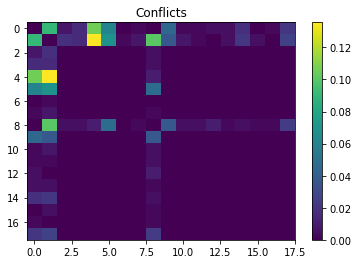

In [38]:
from  metal.contrib.visualization.analysis import view_conflicts

# Viewing conflicts
view_conflicts(Ls[1], normalize=True)

## 5.3: Train a Label Model in Snorkel MeTaL

Next, we use the Snorkel MeTaL model training API to train a `LabelModel` that learns the accuracies of our LFs.  This is the core step that the data programming technique simplifies and formalizes -- by combining our labeling functions based on their accuracies, we can recover a model that outputs reasonable weak labels.

We perform a simple random hyperparameter search over learning rate and L2 regularization, using our small labeled development set to choose the best model.  

In [39]:
from metal.label_model import LabelModel
from metal.logging import LogWriter
from metal.tuners import RandomSearchTuner

# Creating search space
search_space = {
        'l2': {'range': [0.0001, 0.1], 'scale':'log'},           # linear range
        'lr': {'range': [0.0001, 0.1], 'scale': 'log'},  # log range
        }

searcher = RandomSearchTuner(LabelModel, log_dir='./run_logs',
            log_writer_class=None)

# Training label model
label_model = searcher.search(search_space, (Ls[1],Ys[1]), \
        train_args=[Ls[0]], init_args=[],
        init_kwargs={'k':2, 'seed':1701}, 
        train_kwargs={'n_epochs':200},
        max_search=40,
        verbose=True)

[0] Testing {'l2': 0.03414016019207298, 'lr': 0.018787249753397045}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.950]
[2 epo]: TRAIN:[loss=1.906]
[3 epo]: TRAIN:[loss=1.822]
[4 epo]: TRAIN:[loss=1.697]
[5 epo]: TRAIN:[loss=1.533]
[6 epo]: TRAIN:[loss=1.331]
[7 epo]: TRAIN:[loss=1.094]
[8 epo]: TRAIN:[loss=0.834]
[9 epo]: TRAIN:[loss=0.571]
[10 epo]: TRAIN:[loss=0.339]
[11 epo]: TRAIN:[loss=0.179]
[12 epo]: TRAIN:[loss=0.130]
[13 epo]: TRAIN:[loss=0.198]
[14 epo]: TRAIN:[loss=0.346]
[15 epo]: TRAIN:[loss=0.492]
[16 epo]: TRAIN:[loss=0.556]
[17 epo]: TRAIN:[loss=0.511]
[18 epo]: TRAIN:[loss=0.391]
[19 epo]: TRAIN:[loss=0.259]
[20 epo]: TRAIN:[loss=0.165]
[21 epo]: TRAIN:[loss=0.127]
[22 epo]: TRAIN:[loss=0.136]
[23 epo]: TRAIN:[loss=0.170]
[24 epo]: TRAIN:[loss=0.209]
[25 epo]: TRAIN:[loss=0.239]
[26 epo]: TRAIN:[loss=0.251]
[27 epo]: TRAIN:[loss=0.244]
[28 epo]: TRAIN:[loss=0.220]
[29 epo]: TRAIN:[loss=0.186]
[30 epo]: TRAIN:[loss=0.148]
[31 epo]: TRAIN:[loss=0.114]
[32 epo]:

[2] Testing {'l2': 0.0034184101089156445, 'lr': 0.0016398435363483186}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.944]
[3 epo]: TRAIN:[loss=1.937]
[4 epo]: TRAIN:[loss=1.927]
[5 epo]: TRAIN:[loss=1.913]
[6 epo]: TRAIN:[loss=1.898]
[7 epo]: TRAIN:[loss=1.880]
[8 epo]: TRAIN:[loss=1.859]
[9 epo]: TRAIN:[loss=1.837]
[10 epo]: TRAIN:[loss=1.813]
[11 epo]: TRAIN:[loss=1.787]
[12 epo]: TRAIN:[loss=1.760]
[13 epo]: TRAIN:[loss=1.731]
[14 epo]: TRAIN:[loss=1.700]
[15 epo]: TRAIN:[loss=1.669]
[16 epo]: TRAIN:[loss=1.636]
[17 epo]: TRAIN:[loss=1.601]
[18 epo]: TRAIN:[loss=1.566]
[19 epo]: TRAIN:[loss=1.530]
[20 epo]: TRAIN:[loss=1.492]
[21 epo]: TRAIN:[loss=1.454]
[22 epo]: TRAIN:[loss=1.415]
[23 epo]: TRAIN:[loss=1.375]
[24 epo]: TRAIN:[loss=1.335]
[25 epo]: TRAIN:[loss=1.293]
[26 epo]: TRAIN:[loss=1.252]
[27 epo]: TRAIN:[loss=1.209]
[28 epo]: TRAIN:[loss=1.167]
[29 epo]: TRAIN:[loss=1.124]
[30 epo]: TRAIN:[loss=1.080]
[31 epo]: TRAIN:[loss=1.037]
[32 ep

[4] Testing {'l2': 0.0026902389885611606, 'lr': 0.005625305567436231}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.935]
[3 epo]: TRAIN:[loss=1.910]
[4 epo]: TRAIN:[loss=1.874]
[5 epo]: TRAIN:[loss=1.828]
[6 epo]: TRAIN:[loss=1.773]
[7 epo]: TRAIN:[loss=1.708]
[8 epo]: TRAIN:[loss=1.634]
[9 epo]: TRAIN:[loss=1.552]
[10 epo]: TRAIN:[loss=1.463]
[11 epo]: TRAIN:[loss=1.365]
[12 epo]: TRAIN:[loss=1.262]
[13 epo]: TRAIN:[loss=1.152]
[14 epo]: TRAIN:[loss=1.038]
[15 epo]: TRAIN:[loss=0.922]
[16 epo]: TRAIN:[loss=0.804]
[17 epo]: TRAIN:[loss=0.688]
[18 epo]: TRAIN:[loss=0.576]
[19 epo]: TRAIN:[loss=0.472]
[20 epo]: TRAIN:[loss=0.377]
[21 epo]: TRAIN:[loss=0.295]
[22 epo]: TRAIN:[loss=0.228]
[23 epo]: TRAIN:[loss=0.178]
[24 epo]: TRAIN:[loss=0.145]
[25 epo]: TRAIN:[loss=0.129]
[26 epo]: TRAIN:[loss=0.127]
[27 epo]: TRAIN:[loss=0.137]
[28 epo]: TRAIN:[loss=0.154]
[29 epo]: TRAIN:[loss=0.175]
[30 epo]: TRAIN:[loss=0.196]
[31 epo]: TRAIN:[loss=0.212]
[32 epo

[6] Testing {'l2': 0.0007006700163436134, 'lr': 0.018510263983441404}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.905]
[3 epo]: TRAIN:[loss=1.822]
[4 epo]: TRAIN:[loss=1.700]
[5 epo]: TRAIN:[loss=1.539]
[6 epo]: TRAIN:[loss=1.340]
[7 epo]: TRAIN:[loss=1.107]
[8 epo]: TRAIN:[loss=0.851]
[9 epo]: TRAIN:[loss=0.590]
[10 epo]: TRAIN:[loss=0.356]
[11 epo]: TRAIN:[loss=0.190]
[12 epo]: TRAIN:[loss=0.128]
[13 epo]: TRAIN:[loss=0.183]
[14 epo]: TRAIN:[loss=0.323]
[15 epo]: TRAIN:[loss=0.471]
[16 epo]: TRAIN:[loss=0.548]
[17 epo]: TRAIN:[loss=0.518]
[18 epo]: TRAIN:[loss=0.408]
[19 epo]: TRAIN:[loss=0.276]
[20 epo]: TRAIN:[loss=0.176]
[21 epo]: TRAIN:[loss=0.130]
[22 epo]: TRAIN:[loss=0.131]
[23 epo]: TRAIN:[loss=0.161]
[24 epo]: TRAIN:[loss=0.199]
[25 epo]: TRAIN:[loss=0.231]
[26 epo]: TRAIN:[loss=0.247]
[27 epo]: TRAIN:[loss=0.244]
[28 epo]: TRAIN:[loss=0.225]
[29 epo]: TRAIN:[loss=0.193]
[30 epo]: TRAIN:[loss=0.156]
[31 epo]: TRAIN:[loss=0.122]
[32 epo

[8] Testing {'l2': 0.05360913106213878, 'lr': 0.08878844052103335}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.953]
[2 epo]: TRAIN:[loss=1.742]
[3 epo]: TRAIN:[loss=1.309]
[4 epo]: TRAIN:[loss=0.678]
[5 epo]: TRAIN:[loss=0.159]
[6 epo]: TRAIN:[loss=0.451]
[7 epo]: TRAIN:[loss=1.136]
[8 epo]: TRAIN:[loss=0.678]
[9 epo]: TRAIN:[loss=0.168]
[10 epo]: TRAIN:[loss=0.320]
[11 epo]: TRAIN:[loss=0.600]
[12 epo]: TRAIN:[loss=0.685]
[13 epo]: TRAIN:[loss=0.542]
[14 epo]: TRAIN:[loss=0.267]
[15 epo]: TRAIN:[loss=0.077]
[16 epo]: TRAIN:[loss=0.194]
[17 epo]: TRAIN:[loss=0.394]
[18 epo]: TRAIN:[loss=0.259]
[19 epo]: TRAIN:[loss=0.061]
[20 epo]: TRAIN:[loss=0.090]
[21 epo]: TRAIN:[loss=0.214]
[22 epo]: TRAIN:[loss=0.260]
[23 epo]: TRAIN:[loss=0.188]
[24 epo]: TRAIN:[loss=0.073]
[25 epo]: TRAIN:[loss=0.044]
[26 epo]: TRAIN:[loss=0.123]
[27 epo]: TRAIN:[loss=0.154]
[28 epo]: TRAIN:[loss=0.081]
[29 epo]: TRAIN:[loss=0.032]
[30 epo]: TRAIN:[loss=0.062]
[31 epo]: TRAIN:[loss=0.105]
[32 epo]: 

[10] Testing {'l2': 0.0008520061074883595, 'lr': 0.015470175650991696}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.912]
[3 epo]: TRAIN:[loss=1.843]
[4 epo]: TRAIN:[loss=1.742]
[5 epo]: TRAIN:[loss=1.609]
[6 epo]: TRAIN:[loss=1.445]
[7 epo]: TRAIN:[loss=1.252]
[8 epo]: TRAIN:[loss=1.035]
[9 epo]: TRAIN:[loss=0.803]
[10 epo]: TRAIN:[loss=0.572]
[11 epo]: TRAIN:[loss=0.365]
[12 epo]: TRAIN:[loss=0.210]
[13 epo]: TRAIN:[loss=0.133]
[14 epo]: TRAIN:[loss=0.147]
[15 epo]: TRAIN:[loss=0.236]
[16 epo]: TRAIN:[loss=0.358]
[17 epo]: TRAIN:[loss=0.457]
[18 epo]: TRAIN:[loss=0.490]
[19 epo]: TRAIN:[loss=0.449]
[20 epo]: TRAIN:[loss=0.358]
[21 epo]: TRAIN:[loss=0.256]
[22 epo]: TRAIN:[loss=0.176]
[23 epo]: TRAIN:[loss=0.132]
[24 epo]: TRAIN:[loss=0.123]
[25 epo]: TRAIN:[loss=0.138]
[26 epo]: TRAIN:[loss=0.165]
[27 epo]: TRAIN:[loss=0.191]
[28 epo]: TRAIN:[loss=0.210]
[29 epo]: TRAIN:[loss=0.216]
[30 epo]: TRAIN:[loss=0.210]
[31 epo]: TRAIN:[loss=0.194]
[32 ep

[12] Testing {'l2': 0.0026087240761925347, 'lr': 0.000200495035857012}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.947]
[3 epo]: TRAIN:[loss=1.946]
[4 epo]: TRAIN:[loss=1.945]
[5 epo]: TRAIN:[loss=1.944]
[6 epo]: TRAIN:[loss=1.942]
[7 epo]: TRAIN:[loss=1.940]
[8 epo]: TRAIN:[loss=1.937]
[9 epo]: TRAIN:[loss=1.934]
[10 epo]: TRAIN:[loss=1.932]
[11 epo]: TRAIN:[loss=1.929]
[12 epo]: TRAIN:[loss=1.925]
[13 epo]: TRAIN:[loss=1.922]
[14 epo]: TRAIN:[loss=1.919]
[15 epo]: TRAIN:[loss=1.915]
[16 epo]: TRAIN:[loss=1.911]
[17 epo]: TRAIN:[loss=1.907]
[18 epo]: TRAIN:[loss=1.904]
[19 epo]: TRAIN:[loss=1.900]
[20 epo]: TRAIN:[loss=1.895]
[21 epo]: TRAIN:[loss=1.891]
[22 epo]: TRAIN:[loss=1.887]
[23 epo]: TRAIN:[loss=1.883]
[24 epo]: TRAIN:[loss=1.879]
[25 epo]: TRAIN:[loss=1.874]
[26 epo]: TRAIN:[loss=1.870]
[27 epo]: TRAIN:[loss=1.865]
[28 epo]: TRAIN:[loss=1.861]
[29 epo]: TRAIN:[loss=1.856]
[30 epo]: TRAIN:[loss=1.852]
[31 epo]: TRAIN:[loss=1.847]
[32 ep

[14] Testing {'l2': 0.054831882914440244, 'lr': 0.07939974420688643}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.953]
[2 epo]: TRAIN:[loss=1.765]
[3 epo]: TRAIN:[loss=1.380]
[4 epo]: TRAIN:[loss=0.809]
[5 epo]: TRAIN:[loss=0.245]
[6 epo]: TRAIN:[loss=0.239]
[7 epo]: TRAIN:[loss=0.925]
[8 epo]: TRAIN:[loss=0.963]
[9 epo]: TRAIN:[loss=0.324]
[10 epo]: TRAIN:[loss=0.176]
[11 epo]: TRAIN:[loss=0.419]
[12 epo]: TRAIN:[loss=0.621]
[13 epo]: TRAIN:[loss=0.627]
[14 epo]: TRAIN:[loss=0.450]
[15 epo]: TRAIN:[loss=0.200]
[16 epo]: TRAIN:[loss=0.072]
[17 epo]: TRAIN:[loss=0.203]
[18 epo]: TRAIN:[loss=0.360]
[19 epo]: TRAIN:[loss=0.243]
[20 epo]: TRAIN:[loss=0.065]
[21 epo]: TRAIN:[loss=0.068]
[22 epo]: TRAIN:[loss=0.172]
[23 epo]: TRAIN:[loss=0.233]
[24 epo]: TRAIN:[loss=0.196]
[25 epo]: TRAIN:[loss=0.099]
[26 epo]: TRAIN:[loss=0.039]
[27 epo]: TRAIN:[loss=0.075]
[28 epo]: TRAIN:[loss=0.136]
[29 epo]: TRAIN:[loss=0.114]
[30 epo]: TRAIN:[loss=0.049]
[31 epo]: TRAIN:[loss=0.033]
[32 epo]

[16] Testing {'l2': 0.0006046122347410976, 'lr': 0.02600659419586936}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.887]
[3 epo]: TRAIN:[loss=1.770]
[4 epo]: TRAIN:[loss=1.594]
[5 epo]: TRAIN:[loss=1.362]
[6 epo]: TRAIN:[loss=1.077]
[7 epo]: TRAIN:[loss=0.757]
[8 epo]: TRAIN:[loss=0.445]
[9 epo]: TRAIN:[loss=0.209]
[10 epo]: TRAIN:[loss=0.129]
[11 epo]: TRAIN:[loss=0.241]
[12 epo]: TRAIN:[loss=0.470]
[13 epo]: TRAIN:[loss=0.647]
[14 epo]: TRAIN:[loss=0.641]
[15 epo]: TRAIN:[loss=0.473]
[16 epo]: TRAIN:[loss=0.275]
[17 epo]: TRAIN:[loss=0.154]
[18 epo]: TRAIN:[loss=0.135]
[19 epo]: TRAIN:[loss=0.182]
[20 epo]: TRAIN:[loss=0.249]
[21 epo]: TRAIN:[loss=0.301]
[22 epo]: TRAIN:[loss=0.321]
[23 epo]: TRAIN:[loss=0.305]
[24 epo]: TRAIN:[loss=0.259]
[25 epo]: TRAIN:[loss=0.198]
[26 epo]: TRAIN:[loss=0.137]
[27 epo]: TRAIN:[loss=0.093]
[28 epo]: TRAIN:[loss=0.078]
[29 epo]: TRAIN:[loss=0.090]
[30 epo]: TRAIN:[loss=0.116]
[31 epo]: TRAIN:[loss=0.136]
[32 epo

[18] Testing {'l2': 0.014424941455201687, 'lr': 0.001572065462871513}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.944]
[3 epo]: TRAIN:[loss=1.938]
[4 epo]: TRAIN:[loss=1.928]
[5 epo]: TRAIN:[loss=1.915]
[6 epo]: TRAIN:[loss=1.900]
[7 epo]: TRAIN:[loss=1.883]
[8 epo]: TRAIN:[loss=1.863]
[9 epo]: TRAIN:[loss=1.842]
[10 epo]: TRAIN:[loss=1.819]
[11 epo]: TRAIN:[loss=1.794]
[12 epo]: TRAIN:[loss=1.768]
[13 epo]: TRAIN:[loss=1.740]
[14 epo]: TRAIN:[loss=1.711]
[15 epo]: TRAIN:[loss=1.681]
[16 epo]: TRAIN:[loss=1.649]
[17 epo]: TRAIN:[loss=1.617]
[18 epo]: TRAIN:[loss=1.583]
[19 epo]: TRAIN:[loss=1.548]
[20 epo]: TRAIN:[loss=1.512]
[21 epo]: TRAIN:[loss=1.476]
[22 epo]: TRAIN:[loss=1.439]
[23 epo]: TRAIN:[loss=1.400]
[24 epo]: TRAIN:[loss=1.362]
[25 epo]: TRAIN:[loss=1.322]
[26 epo]: TRAIN:[loss=1.282]
[27 epo]: TRAIN:[loss=1.242]
[28 epo]: TRAIN:[loss=1.201]
[29 epo]: TRAIN:[loss=1.160]
[30 epo]: TRAIN:[loss=1.118]
[31 epo]: TRAIN:[loss=1.077]
[32 epo

[20] Testing {'l2': 0.00010079255584239314, 'lr': 0.0030250572583097987}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.941]
[3 epo]: TRAIN:[loss=1.927]
[4 epo]: TRAIN:[loss=1.908]
[5 epo]: TRAIN:[loss=1.884]
[6 epo]: TRAIN:[loss=1.855]
[7 epo]: TRAIN:[loss=1.821]
[8 epo]: TRAIN:[loss=1.783]
[9 epo]: TRAIN:[loss=1.741]
[10 epo]: TRAIN:[loss=1.695]
[11 epo]: TRAIN:[loss=1.645]
[12 epo]: TRAIN:[loss=1.592]
[13 epo]: TRAIN:[loss=1.536]
[14 epo]: TRAIN:[loss=1.477]
[15 epo]: TRAIN:[loss=1.415]
[16 epo]: TRAIN:[loss=1.351]
[17 epo]: TRAIN:[loss=1.284]
[18 epo]: TRAIN:[loss=1.215]
[19 epo]: TRAIN:[loss=1.145]
[20 epo]: TRAIN:[loss=1.074]
[21 epo]: TRAIN:[loss=1.001]
[22 epo]: TRAIN:[loss=0.928]
[23 epo]: TRAIN:[loss=0.855]
[24 epo]: TRAIN:[loss=0.783]
[25 epo]: TRAIN:[loss=0.712]
[26 epo]: TRAIN:[loss=0.643]
[27 epo]: TRAIN:[loss=0.577]
[28 epo]: TRAIN:[loss=0.513]
[29 epo]: TRAIN:[loss=0.453]
[30 epo]: TRAIN:[loss=0.398]
[31 epo]: TRAIN:[loss=0.347]
[32 

[22] Testing {'l2': 0.0009453945366865167, 'lr': 0.040870852484767635}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.853]
[3 epo]: TRAIN:[loss=1.664]
[4 epo]: TRAIN:[loss=1.379]
[5 epo]: TRAIN:[loss=1.004]
[6 epo]: TRAIN:[loss=0.582]
[7 epo]: TRAIN:[loss=0.231]
[8 epo]: TRAIN:[loss=0.139]
[9 epo]: TRAIN:[loss=0.399]
[10 epo]: TRAIN:[loss=0.759]
[11 epo]: TRAIN:[loss=0.800]
[12 epo]: TRAIN:[loss=0.502]
[13 epo]: TRAIN:[loss=0.214]
[14 epo]: TRAIN:[loss=0.143]
[15 epo]: TRAIN:[loss=0.232]
[16 epo]: TRAIN:[loss=0.356]
[17 epo]: TRAIN:[loss=0.431]
[18 epo]: TRAIN:[loss=0.430]
[19 epo]: TRAIN:[loss=0.358]
[20 epo]: TRAIN:[loss=0.244]
[21 epo]: TRAIN:[loss=0.135]
[22 epo]: TRAIN:[loss=0.077]
[23 epo]: TRAIN:[loss=0.097]
[24 epo]: TRAIN:[loss=0.163]
[25 epo]: TRAIN:[loss=0.204]
[26 epo]: TRAIN:[loss=0.176]
[27 epo]: TRAIN:[loss=0.105]
[28 epo]: TRAIN:[loss=0.047]
[29 epo]: TRAIN:[loss=0.034]
[30 epo]: TRAIN:[loss=0.055]
[31 epo]: TRAIN:[loss=0.086]
[32 ep

[24] Testing {'l2': 0.0005198137771290033, 'lr': 0.07991361019072307}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.760]
[3 epo]: TRAIN:[loss=1.375]
[4 epo]: TRAIN:[loss=0.803]
[5 epo]: TRAIN:[loss=0.239]
[6 epo]: TRAIN:[loss=0.242]
[7 epo]: TRAIN:[loss=0.932]
[8 epo]: TRAIN:[loss=0.953]
[9 epo]: TRAIN:[loss=0.313]
[10 epo]: TRAIN:[loss=0.179]
[11 epo]: TRAIN:[loss=0.427]
[12 epo]: TRAIN:[loss=0.626]
[13 epo]: TRAIN:[loss=0.627]
[14 epo]: TRAIN:[loss=0.446]
[15 epo]: TRAIN:[loss=0.196]
[16 epo]: TRAIN:[loss=0.076]
[17 epo]: TRAIN:[loss=0.217]
[18 epo]: TRAIN:[loss=0.365]
[19 epo]: TRAIN:[loss=0.234]
[20 epo]: TRAIN:[loss=0.059]
[21 epo]: TRAIN:[loss=0.069]
[22 epo]: TRAIN:[loss=0.174]
[23 epo]: TRAIN:[loss=0.232]
[24 epo]: TRAIN:[loss=0.192]
[25 epo]: TRAIN:[loss=0.095]
[26 epo]: TRAIN:[loss=0.039]
[27 epo]: TRAIN:[loss=0.081]
[28 epo]: TRAIN:[loss=0.138]
[29 epo]: TRAIN:[loss=0.109]
[30 epo]: TRAIN:[loss=0.043]
[31 epo]: TRAIN:[loss=0.032]
[32 epo

[26] Testing {'l2': 0.00017431608187606305, 'lr': 0.0009123549108236436}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.946]
[3 epo]: TRAIN:[loss=1.942]
[4 epo]: TRAIN:[loss=1.936]
[5 epo]: TRAIN:[loss=1.929]
[6 epo]: TRAIN:[loss=1.920]
[7 epo]: TRAIN:[loss=1.910]
[8 epo]: TRAIN:[loss=1.899]
[9 epo]: TRAIN:[loss=1.887]
[10 epo]: TRAIN:[loss=1.874]
[11 epo]: TRAIN:[loss=1.859]
[12 epo]: TRAIN:[loss=1.845]
[13 epo]: TRAIN:[loss=1.829]
[14 epo]: TRAIN:[loss=1.813]
[15 epo]: TRAIN:[loss=1.795]
[16 epo]: TRAIN:[loss=1.778]
[17 epo]: TRAIN:[loss=1.760]
[18 epo]: TRAIN:[loss=1.741]
[19 epo]: TRAIN:[loss=1.722]
[20 epo]: TRAIN:[loss=1.702]
[21 epo]: TRAIN:[loss=1.682]
[22 epo]: TRAIN:[loss=1.661]
[23 epo]: TRAIN:[loss=1.640]
[24 epo]: TRAIN:[loss=1.619]
[25 epo]: TRAIN:[loss=1.597]
[26 epo]: TRAIN:[loss=1.575]
[27 epo]: TRAIN:[loss=1.553]
[28 epo]: TRAIN:[loss=1.530]
[29 epo]: TRAIN:[loss=1.507]
[30 epo]: TRAIN:[loss=1.484]
[31 epo]: TRAIN:[loss=1.461]
[32 

[28] Testing {'l2': 0.00021240930493068353, 'lr': 0.0045061094714809475}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.937]
[3 epo]: TRAIN:[loss=1.918]
[4 epo]: TRAIN:[loss=1.889]
[5 epo]: TRAIN:[loss=1.852]
[6 epo]: TRAIN:[loss=1.808]
[7 epo]: TRAIN:[loss=1.757]
[8 epo]: TRAIN:[loss=1.699]
[9 epo]: TRAIN:[loss=1.634]
[10 epo]: TRAIN:[loss=1.564]
[11 epo]: TRAIN:[loss=1.488]
[12 epo]: TRAIN:[loss=1.406]
[13 epo]: TRAIN:[loss=1.319]
[14 epo]: TRAIN:[loss=1.228]
[15 epo]: TRAIN:[loss=1.134]
[16 epo]: TRAIN:[loss=1.037]
[17 epo]: TRAIN:[loss=0.937]
[18 epo]: TRAIN:[loss=0.838]
[19 epo]: TRAIN:[loss=0.739]
[20 epo]: TRAIN:[loss=0.643]
[21 epo]: TRAIN:[loss=0.551]
[22 epo]: TRAIN:[loss=0.464]
[23 epo]: TRAIN:[loss=0.385]
[24 epo]: TRAIN:[loss=0.315]
[25 epo]: TRAIN:[loss=0.256]
[26 epo]: TRAIN:[loss=0.207]
[27 epo]: TRAIN:[loss=0.171]
[28 epo]: TRAIN:[loss=0.145]
[29 epo]: TRAIN:[loss=0.131]
[30 epo]: TRAIN:[loss=0.126]
[31 epo]: TRAIN:[loss=0.128]
[32 

[30] Testing {'l2': 0.02775879373828576, 'lr': 0.004176868675879894}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.949]
[2 epo]: TRAIN:[loss=1.939]
[3 epo]: TRAIN:[loss=1.921]
[4 epo]: TRAIN:[loss=1.895]
[5 epo]: TRAIN:[loss=1.861]
[6 epo]: TRAIN:[loss=1.820]
[7 epo]: TRAIN:[loss=1.772]
[8 epo]: TRAIN:[loss=1.719]
[9 epo]: TRAIN:[loss=1.659]
[10 epo]: TRAIN:[loss=1.594]
[11 epo]: TRAIN:[loss=1.524]
[12 epo]: TRAIN:[loss=1.448]
[13 epo]: TRAIN:[loss=1.368]
[14 epo]: TRAIN:[loss=1.284]
[15 epo]: TRAIN:[loss=1.197]
[16 epo]: TRAIN:[loss=1.106]
[17 epo]: TRAIN:[loss=1.014]
[18 epo]: TRAIN:[loss=0.920]
[19 epo]: TRAIN:[loss=0.826]
[20 epo]: TRAIN:[loss=0.733]
[21 epo]: TRAIN:[loss=0.642]
[22 epo]: TRAIN:[loss=0.556]
[23 epo]: TRAIN:[loss=0.474]
[24 epo]: TRAIN:[loss=0.399]
[25 epo]: TRAIN:[loss=0.331]
[26 epo]: TRAIN:[loss=0.273]
[27 epo]: TRAIN:[loss=0.224]
[28 epo]: TRAIN:[loss=0.186]
[29 epo]: TRAIN:[loss=0.157]
[30 epo]: TRAIN:[loss=0.139]
[31 epo]: TRAIN:[loss=0.129]
[32 epo]

[32] Testing {'l2': 0.0057923019390401145, 'lr': 0.0021625545876511687}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.943]
[3 epo]: TRAIN:[loss=1.933]
[4 epo]: TRAIN:[loss=1.920]
[5 epo]: TRAIN:[loss=1.902]
[6 epo]: TRAIN:[loss=1.882]
[7 epo]: TRAIN:[loss=1.858]
[8 epo]: TRAIN:[loss=1.831]
[9 epo]: TRAIN:[loss=1.801]
[10 epo]: TRAIN:[loss=1.769]
[11 epo]: TRAIN:[loss=1.734]
[12 epo]: TRAIN:[loss=1.697]
[13 epo]: TRAIN:[loss=1.658]
[14 epo]: TRAIN:[loss=1.617]
[15 epo]: TRAIN:[loss=1.575]
[16 epo]: TRAIN:[loss=1.530]
[17 epo]: TRAIN:[loss=1.484]
[18 epo]: TRAIN:[loss=1.436]
[19 epo]: TRAIN:[loss=1.387]
[20 epo]: TRAIN:[loss=1.336]
[21 epo]: TRAIN:[loss=1.284]
[22 epo]: TRAIN:[loss=1.232]
[23 epo]: TRAIN:[loss=1.178]
[24 epo]: TRAIN:[loss=1.124]
[25 epo]: TRAIN:[loss=1.069]
[26 epo]: TRAIN:[loss=1.014]
[27 epo]: TRAIN:[loss=0.959]
[28 epo]: TRAIN:[loss=0.904]
[29 epo]: TRAIN:[loss=0.849]
[30 epo]: TRAIN:[loss=0.795]
[31 epo]: TRAIN:[loss=0.742]
[32 e

[70 epo]: TRAIN:[loss=0.152]
[71 epo]: TRAIN:[loss=0.146]
[72 epo]: TRAIN:[loss=0.142]
[73 epo]: TRAIN:[loss=0.138]
[74 epo]: TRAIN:[loss=0.134]
[75 epo]: TRAIN:[loss=0.131]
[76 epo]: TRAIN:[loss=0.129]
[77 epo]: TRAIN:[loss=0.127]
[78 epo]: TRAIN:[loss=0.125]
[79 epo]: TRAIN:[loss=0.124]
[80 epo]: TRAIN:[loss=0.122]
[81 epo]: TRAIN:[loss=0.122]
[82 epo]: TRAIN:[loss=0.121]
[83 epo]: TRAIN:[loss=0.120]
[84 epo]: TRAIN:[loss=0.120]
[85 epo]: TRAIN:[loss=0.119]
[86 epo]: TRAIN:[loss=0.119]
[87 epo]: TRAIN:[loss=0.118]
[88 epo]: TRAIN:[loss=0.118]
[89 epo]: TRAIN:[loss=0.118]
[90 epo]: TRAIN:[loss=0.117]
[91 epo]: TRAIN:[loss=0.117]
[92 epo]: TRAIN:[loss=0.117]
[93 epo]: TRAIN:[loss=0.117]
[94 epo]: TRAIN:[loss=0.116]
[95 epo]: TRAIN:[loss=0.116]
[96 epo]: TRAIN:[loss=0.116]
[97 epo]: TRAIN:[loss=0.116]
[98 epo]: TRAIN:[loss=0.115]
[99 epo]: TRAIN:[loss=0.115]
[100 epo]: TRAIN:[loss=0.115]
[101 epo]: TRAIN:[loss=0.115]
[102 epo]: TRAIN:[loss=0.114]
[103 epo]: TRAIN:[loss=0.114]
[104 epo]:

[35] Testing {'l2': 0.00036997636884157745, 'lr': 0.0003632357492870933}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.947]
[3 epo]: TRAIN:[loss=1.945]
[4 epo]: TRAIN:[loss=1.943]
[5 epo]: TRAIN:[loss=1.940]
[6 epo]: TRAIN:[loss=1.937]
[7 epo]: TRAIN:[loss=1.933]
[8 epo]: TRAIN:[loss=1.928]
[9 epo]: TRAIN:[loss=1.924]
[10 epo]: TRAIN:[loss=1.918]
[11 epo]: TRAIN:[loss=1.913]
[12 epo]: TRAIN:[loss=1.907]
[13 epo]: TRAIN:[loss=1.901]
[14 epo]: TRAIN:[loss=1.895]
[15 epo]: TRAIN:[loss=1.888]
[16 epo]: TRAIN:[loss=1.881]
[17 epo]: TRAIN:[loss=1.874]
[18 epo]: TRAIN:[loss=1.867]
[19 epo]: TRAIN:[loss=1.860]
[20 epo]: TRAIN:[loss=1.852]
[21 epo]: TRAIN:[loss=1.845]
[22 epo]: TRAIN:[loss=1.837]
[23 epo]: TRAIN:[loss=1.829]
[24 epo]: TRAIN:[loss=1.821]
[25 epo]: TRAIN:[loss=1.813]
[26 epo]: TRAIN:[loss=1.805]
[27 epo]: TRAIN:[loss=1.797]
[28 epo]: TRAIN:[loss=1.788]
[29 epo]: TRAIN:[loss=1.780]
[30 epo]: TRAIN:[loss=1.771]
[31 epo]: TRAIN:[loss=1.763]
[32 

[37] Testing {'l2': 0.0026890134594752878, 'lr': 0.00018598292923933146}
Computing O...
Estimating \mu...
[1 epo]: TRAIN:[loss=1.948]
[2 epo]: TRAIN:[loss=1.947]
[3 epo]: TRAIN:[loss=1.947]
[4 epo]: TRAIN:[loss=1.945]
[5 epo]: TRAIN:[loss=1.944]
[6 epo]: TRAIN:[loss=1.942]
[7 epo]: TRAIN:[loss=1.940]
[8 epo]: TRAIN:[loss=1.938]
[9 epo]: TRAIN:[loss=1.935]
[10 epo]: TRAIN:[loss=1.933]
[11 epo]: TRAIN:[loss=1.930]
[12 epo]: TRAIN:[loss=1.927]
[13 epo]: TRAIN:[loss=1.924]
[14 epo]: TRAIN:[loss=1.921]
[15 epo]: TRAIN:[loss=1.917]
[16 epo]: TRAIN:[loss=1.914]
[17 epo]: TRAIN:[loss=1.910]
[18 epo]: TRAIN:[loss=1.907]
[19 epo]: TRAIN:[loss=1.903]
[20 epo]: TRAIN:[loss=1.899]
[21 epo]: TRAIN:[loss=1.895]
[22 epo]: TRAIN:[loss=1.892]
[23 epo]: TRAIN:[loss=1.888]
[24 epo]: TRAIN:[loss=1.884]
[25 epo]: TRAIN:[loss=1.880]
[26 epo]: TRAIN:[loss=1.876]
[27 epo]: TRAIN:[loss=1.871]
[28 epo]: TRAIN:[loss=1.867]
[29 epo]: TRAIN:[loss=1.863]
[30 epo]: TRAIN:[loss=1.859]
[31 epo]: TRAIN:[loss=1.855]
[32 

[70 epo]: TRAIN:[loss=0.023]
[71 epo]: TRAIN:[loss=0.023]
[72 epo]: TRAIN:[loss=0.024]
[73 epo]: TRAIN:[loss=0.024]
[74 epo]: TRAIN:[loss=0.024]
[75 epo]: TRAIN:[loss=0.024]
[76 epo]: TRAIN:[loss=0.023]
[77 epo]: TRAIN:[loss=0.023]
[78 epo]: TRAIN:[loss=0.023]
[79 epo]: TRAIN:[loss=0.023]
[80 epo]: TRAIN:[loss=0.023]
[81 epo]: TRAIN:[loss=0.023]
[82 epo]: TRAIN:[loss=0.023]
[83 epo]: TRAIN:[loss=0.023]
[84 epo]: TRAIN:[loss=0.023]
[85 epo]: TRAIN:[loss=0.023]
[86 epo]: TRAIN:[loss=0.023]
[87 epo]: TRAIN:[loss=0.023]
[88 epo]: TRAIN:[loss=0.023]
[89 epo]: TRAIN:[loss=0.023]
[90 epo]: TRAIN:[loss=0.023]
[91 epo]: TRAIN:[loss=0.023]
[92 epo]: TRAIN:[loss=0.023]
[93 epo]: TRAIN:[loss=0.023]
[94 epo]: TRAIN:[loss=0.023]
[95 epo]: TRAIN:[loss=0.023]
[96 epo]: TRAIN:[loss=0.023]
[97 epo]: TRAIN:[loss=0.023]
[98 epo]: TRAIN:[loss=0.023]
[99 epo]: TRAIN:[loss=0.023]
[100 epo]: TRAIN:[loss=0.023]
[101 epo]: TRAIN:[loss=0.023]
[102 epo]: TRAIN:[loss=0.023]
[103 epo]: TRAIN:[loss=0.023]
[104 epo]:

[SUMMARY]
Best model: [2]
Best config: {'l2': 0.0034184101089156445, 'lr': 0.0016398435363483186}
Best score: 0.8617021276595744


We evaluate our best model on the development set as below -- you should recover a model with best accuracy of approximately 85% on the development set -- this `LabelModel`will be applied to the training set to create weak labels, which we can then use to train our image classifier.

In [40]:
# Getting scores
scores = label_model.score((Ls[1], Ys[1]), metric=['accuracy','precision', 'recall', 'f1', 'roc-auc'])

Accuracy: 0.862
Precision: 0.863
Recall: 0.928
F1: 0.894
Roc-auc: 0.929
        y=1    y=2   
 l=1    220    17    
 l=2    35     104   


Why is this useful?  If we compare to majority vote, we see a couple points of improvement in accuracy.  Note that the degree to which we expect this model to improve over majority vote varies based on the type of dataset involved, as detailed in the 2018 [VLDB Paper](http://www.vldb.org/pvldb/vol11/p269-ratner.pdf) describing the Snorkel system.

In [41]:
from metal.label_model.baselines import MajorityLabelVoter

# Checking if we beat majority vote
mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

Accuracy: 0.835
Precision: 0.828
Recall: 0.932
F1: 0.877
Roc-auc: 0.871
        y=1    y=2   
 l=1    221    16    
 l=2    46     93    


## 5.4: Create a Weakly Labeled Training Set

We can now use this trained `LabelModel` to create weak labels for each of our train, development, and test splits by applying it to the label matrices, as below.

In [42]:
Y_train_ps = label_model.predict_proba(Ls[0])
Y_dev_ps = label_model.predict_proba(Ls[1])
Y_test_ps = label_model.predict_proba(Ls[2])
Y_ps = [Y_train_ps, Y_dev_ps, Y_test_ps]

We can inspect the distribution of our weak training labels, and note that they are assigned varying degrees of probability.  An advantage of this labeling approach is that probabilistic labels can be very descriptive -- i.e., if an example has a 60% probability of being abnormal, we train against that 0.6 probability, rather than binarizing to 100%.  

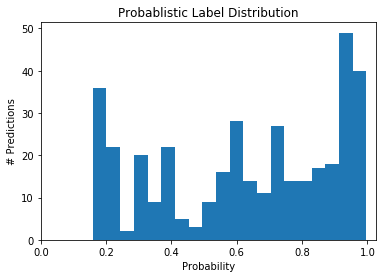

In [43]:
from  metal.contrib.visualization.analysis  import plot_probabilities_histogram

# Looking at probability histogram for training labels
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

Using the development set, we can also check that the class balance of our weak labels if we were to naively binarize at the 0.5 cutoff -- we see reasonable behavior here.

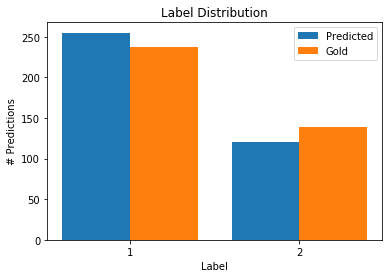

In [44]:
from metal.contrib.visualization.analysis import plot_predictions_histogram
# Obtaining binarized predictions
Y_dev_p = label_model.predict(Ls[1])
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## 5.5: Train a Weakly Supervised End Model

Now that we have our weak training labels, we can train a commodity CNN using a simple PyTorch API.  In Snorkel MeTaL, we have written high-level utilities to do this.  The entire process of defining and training the model can be executed in the following two simple cells.

First, we define PyTorch `DataLoader` objects to efficiently load our image data, associating each image with the weak label generated from its associated report.

In [45]:
import torch
from torchvision import models
from metal.end_model import EndModel
from metal.logging.tensorboard import TensorBoardWriter
from utils import get_data_loader

# Setting up log directory
log_config = {"log_dir": "./run_logs", "run_name": 'openi_demo_ws'}
tuner_config = {"max_search": 1}
search_space = {
    "l2": [0.0005],  # linear range
    "lr": [0.001]
}

# Create pytorch model
num_classes = 2
resnet = models.resnet18(pretrained=True)
last_layer_input_size = int(resnet.fc.weight.size()[1])
resnet.fc = torch.nn.Linear(last_layer_input_size, num_classes)

# Create data loaders
loaders = {}
loaders['train'] = get_data_loader(data['train']['xray_paths'].tolist(), Y_ps[0], batch_size=32, shuffle=True)
loaders['dev'] = get_data_loader(data['dev']['xray_paths'].tolist(), Ys[1], batch_size=32, shuffle=False)
loaders['test'] = get_data_loader(data['test']['xray_paths'].tolist(), Ys[2], batch_size=32, shuffle=False)

As an example, a single datapoint yields an image like this:

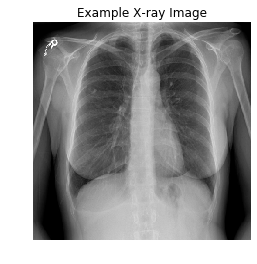

In [46]:
import matplotlib.pyplot as plt
img, label = loaders['train'].dataset[0]

plt.figure()
plt.imshow(img[0,:,:],cmap='gray')
plt.title('Example X-ray Image')
ax = plt.axis('off')

Now that our `DataLoaders` are set up, it is a simple matter to define and train our CNN model. 

Note: While this will run if you do not have a CUDA-based GPU available (and will automatically detect it if you do), it will proceed *much* faster if you have one!  CPU-only per-epoch training time is ~ 15 minutes, while with a Titan X it is approximately 30 s!

In [47]:
# Defining network parameters
num_classes = 2
pretrained = True
train_args = [loaders['train']]
init_args = [[num_classes]]

# Defining device variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initializing input module
init_kwargs = {"input_module": resnet, 
               "skip_head": True,
               "input_relu": False,
               "input_batchnorm": False,
               "device": device,
               'seed':1701}

# Setting up logger and searcher
searcher = RandomSearchTuner(EndModel, 
    **log_config, log_writer_class=TensorBoardWriter, 
    validation_metric='accuracy',
    seed=1701)

# Training weakly supervised model
weakly_supervised_model = searcher.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

[1 epo]: TRAIN:[loss=0.685] VALID:[accuracy=0.729]
Saving model at iteration 1 with best score 0.729



[2 epo]: TRAIN:[loss=0.654] VALID:[accuracy=0.713]



[3 epo]: TRAIN:[loss=0.646] VALID:[accuracy=0.638]



[4 epo]: TRAIN:[loss=0.647] VALID:[accuracy=0.676]



[5 epo]: TRAIN:[loss=0.651] VALID:[accuracy=0.670]



[6 epo]: TRAIN:[loss=0.645] VALID:[accuracy=0.641]



[7 epo]: TRAIN:[loss=0.650] VALID:[accuracy=0.630]



[8 epo]: TRAIN:[loss=0.648] VALID:[accuracy=0.630]



[9 epo]: TRAIN:[loss=0.645] VALID:[accuracy=0.630]



[10 epo]: TRAIN:[loss=0.646] VALID:[accuracy=0.691]

Restoring best model from iteration 1 with score 0.729
Finished Training
Accuracy: 0.729
        y=1    y=2   
 l=1    189    48    
 l=2    54     85    
[SUMMARY]
Best model: [0]
Best config: {'l2': 0.0005, 'lr': 0.001}
Best score: 0.7287234042553191


We can evaluate this model below, and see that we've learned some useful signal!  Remember that an Area Under the Receiver Operating Characteristic (ROC-AUC) score represents the probability across all possible cutoffs of ranking an abnormal example higher than a normal example.  If we've learned nothing useful, this value would be 0.5. 

You should expect a value just above 0.70 for this training run.

In [48]:
# Evaluating model
print (f"Evaluating Weakly Supervised Model")
scores = weakly_supervised_model.score(
    loaders['test'], metric=["roc-auc"]
)

Evaluating Weakly Supervised Model
Roc-auc: 0.745
        y=1    y=2   
 l=1    180    53    
 l=2    60     85    


## 5.6: Comparing to a Fully Supervised End Model

We trained fully supervised models in the earlier sections of this notebook, so we can compare the performance of fully supervised to weakly supervised models.

Now, we can evaluate the weakly and fully supervised models, observing that they achieve similar Area Under the Receiver Operating Characteristic (ROC-AUC) scores.  Note that due to the small size of the dataset and that we are not tuning the cutoff for a particular performance score, we report ROC-AUC in this demo.

In [49]:
# Evaluating weakly model
print (f"Evaluating Weakly Supervised Model")
weakly_supervised_scores = weakly_supervised_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)
print()
# Evaluating fully supervised model
print (f"Evaluating Fully Supervised Model")
advanced_pretrained_scores = advanced_pretrained_model.score(
    loaders['test'], metric=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'], print_confusion_matrix=False,
)

Evaluating Weakly Supervised Model
Accuracy: 0.701
Precision: 0.750
Recall: 0.773
F1: 0.761
Roc-auc: 0.745

Evaluating Fully Supervised Model
Accuracy: 0.690
Precision: 0.716
Recall: 0.824
F1: 0.766
Roc-auc: 0.729


If the models have trained successfully, you should observe that the weakly and fully supervised models both achieve ROC-AUC scores around 0.70.  This indicates that the weak labels we created using our labeling functions over the text have successfully allowed us to train a CNN model that performs very similarly to one trained using ground truth, but *without having to label thousands of images*.

Congratulations! You've just trained a deep learning model using cross-modal data programming!  We hope this demo is helpful in your research, and check for updates to Snorkel and Snorkel MeTaL at [snorkel.stanford.edu](snorkel.stanford.edu)!